In [1]:
import pandas as pd
import numpy as np
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk import ngrams
from nltk.probability import FreqDist
from langdetect import detect
import matplotlib.pyplot as plt; plt.rcdefaults()
from gensim.models import word2vec
from sklearn.ensemble import RandomForestClassifier


In [2]:
#jupyter notebook setting: to show the full texts in the output window
pd.set_option('display.max_colwidth', -1)

In [5]:
#input file:  tweet dataset
rawTweetData=pd.read_csv('/Users/Mandy/Study/SpringBoard/Capstone 2/GoldTweetDataWorkBook.csv',encoding='latin1')
print(rawTweetData.head())


       date  score  language  \
0  12/31/17 -1     NaN         
1  12/31/17  0     NaN         
2  12/31/17  1     NaN         
3  12/31/17  0     NaN         
4  12/31/17  0     NaN         

                                                                                                                                                       text  
0  Steve Harrigan reports on @POTUS ' #NewYearsEve - from the U.S. economy to tonight's party at Mar-a-Lago. #FoxNews2018 pic.twitter.com/wb75BhZ37F         
1  Iran's protests are partly a reaction to a sputtering economy . But there's something bigger at play. http:// cnn.it/2En0qtL pic.twitter.com/lIKazEzNRf   
2  Just a reminder Britney Spears singlehandedly saved the economy by releasing Work Bitch.                                                                  
3  No                                                                                                                                                        
4  Wondering what

In [6]:
#function to detect non-English tweets and delete those rows
def findLanguage(row):
    try:
        return detect(row)
    except:
        return "empty"

In [7]:
#preprocessing 1/4 : delete non-English rows
rawTweetData.language = rawTweetData.text.apply(findLanguage)
rawTweetData=rawTweetData[rawTweetData.language=='en']
rawTweetData=rawTweetData.loc[:,['date','score','language','text']]
print(rawTweetData.head())

       date  score language  \
0  12/31/17 -1      en        
1  12/31/17  0      en        
2  12/31/17  1      en        
4  12/31/17  0      en        
5  12/31/17 -1      en        

                                                                                                                                                                                                                                                             text  
0  Steve Harrigan reports on @POTUS ' #NewYearsEve - from the U.S. economy to tonight's party at Mar-a-Lago. #FoxNews2018 pic.twitter.com/wb75BhZ37F                                                                                                               
1  Iran's protests are partly a reaction to a sputtering economy . But there's something bigger at play. http:// cnn.it/2En0qtL pic.twitter.com/lIKazEzNRf                                                                                                         
2  Just a reminder Britney Spears

In [8]:
#preprocessing 2/4: replace special characters, such as URLs, usernames, hashtags, pictures
#also remove all the special characters
for row in rawTweetData.index:
    eachTweet=rawTweetData.text[row]
    eachTweet_url=re.sub(r"https:// \S+","URL",eachTweet)
    eachTweet_pic=re.sub(r"pic.\S+","PICTURE",eachTweet_url)
    eachTweet_user=re.sub(r"@\S+","USER",eachTweet_pic)
    eachTweet_hashtag=re.sub(r"#\S+","HASHTAG",eachTweet_user)
    eachTweet_spechar=re.sub("[^A-Za-z0-9]+"," ",eachTweet_hashtag).lower()
    rawTweetData.set_value(row,'Tweet',eachTweet_spechar)
print(rawTweetData.head())

       date  score language  \
0  12/31/17 -1      en        
1  12/31/17  0      en        
2  12/31/17  1      en        
4  12/31/17  0      en        
5  12/31/17 -1      en        

                                                                                                                                                                                                                                                             text  \
0  Steve Harrigan reports on @POTUS ' #NewYearsEve - from the U.S. economy to tonight's party at Mar-a-Lago. #FoxNews2018 pic.twitter.com/wb75BhZ37F                                                                                                                
1  Iran's protests are partly a reaction to a sputtering economy . But there's something bigger at play. http:// cnn.it/2En0qtL pic.twitter.com/lIKazEzNRf                                                                                                          
2  Just a reminder Britney Spe

In [9]:
#preprocessing 3/4: Split tweet text word by word (tokenize)
tokenizedTweet = rawTweetData.apply(lambda row: word_tokenize(row['Tweet']), axis=1)
print(tokenizedTweet.head())

0    [steve, harrigan, reports, on, user, hashtag, from, the, u, s, economy, to, tonight, s, party, at, mar, a, lago, hashtag, picture]                                                                                                                                                        
1    [iran, s, protests, are, partly, a, reaction, to, a, sputtering, economy, but, there, s, something, bigger, at, play, http, cnn, it, 2en0qtl, picture]                                                                                                                                    
2    [just, a, reminder, britney, spears, singlehandedly, saved, the, economy, by, releasing, work, bitch]                                                                                                                                                                                     
4    [wondering, what, s, going, on, with, ecuador, s, economy, wonder, how, bitcoin, can, help, read, our, informative, article, on, ou

In [10]:
#preprocessing 4/4: remove stopwords( words that don't have any positive/negative meanings)
filteredTweet = tokenizedTweet.apply(lambda x: [word for word in x if word not in stopwords.words('english')])
print(filteredTweet.head())

0    [steve, harrigan, reports, user, hashtag, u, economy, tonight, party, mar, lago, hashtag, picture]                                                                                                             
1    [iran, protests, partly, reaction, sputtering, economy, something, bigger, play, http, cnn, 2en0qtl, picture]                                                                                                  
2    [reminder, britney, spears, singlehandedly, saved, economy, releasing, work, bitch]                                                                                                                            
4    [wondering, going, ecuador, economy, wonder, bitcoin, help, read, informative, article, blog, http, ow, ly, 53lb30hvquu]                                                                                       
5    [still, wait, see, streets, however, least, three, different, camps, recent, days, gov, economy, corruption, green, camp, 2009, election, prote

In [11]:
#Tweet data after all the pre-processing steps
tweetData=rawTweetData.loc[:,['date','score']]
tweetData=pd.concat([tweetData, filteredTweet], axis=1)
tweetData.columns=['date','score','tweet']
print(tweetData.head())

       date  score  \
0  12/31/17 -1       
1  12/31/17  0       
2  12/31/17  1       
4  12/31/17  0       
5  12/31/17 -1       

                                                                                                                                                                                                             tweet  
0  [steve, harrigan, reports, user, hashtag, u, economy, tonight, party, mar, lago, hashtag, picture]                                                                                                               
1  [iran, protests, partly, reaction, sputtering, economy, something, bigger, play, http, cnn, 2en0qtl, picture]                                                                                                    
2  [reminder, britney, spears, singlehandedly, saved, economy, releasing, work, bitch]                                                                                                                              
4  [wondering, 

In [12]:
#function to combine every words from all the tweets into a word library
def get_words_in_tweets(tweets):
    all_words = []
    for words in tweets:
        all_words.extend(words)
    return all_words

#call the function
word_list=get_words_in_tweets(filteredTweet)

In [13]:
# a distribution table of words and their corresponding frequencies
word_features=FreqDist(word for word in word_list)
word_freq=[word_features[w] for w in word_features]
target_word=list(word_features.keys())
word_freq=pd.DataFrame(word_freq)
target_word=pd.DataFrame(target_word)
word_freq_dist=pd.concat([target_word,word_freq],axis=1)
word_freq_dist.columns=['target_word','frequency']
word_freq_dist=word_freq_dist.sort_values('frequency',ascending=False)
print(word_freq_dist.head())

    target_word  frequency
6    economy     10418    
4    hashtag     8418     
3    user        5522     
195  economic    5107     
11   picture     3130     


In [14]:
#delete rows with the replacement words: URL, PICTURE, USER, HASHTAG
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'url']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'http']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'picture']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'user']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'hashtag']
print(word_freq_dist.head())

    target_word  frequency
6    economy     10418    
195  economic    5107     
83   trump       2545     
126  us          1353     
300  people      1152     


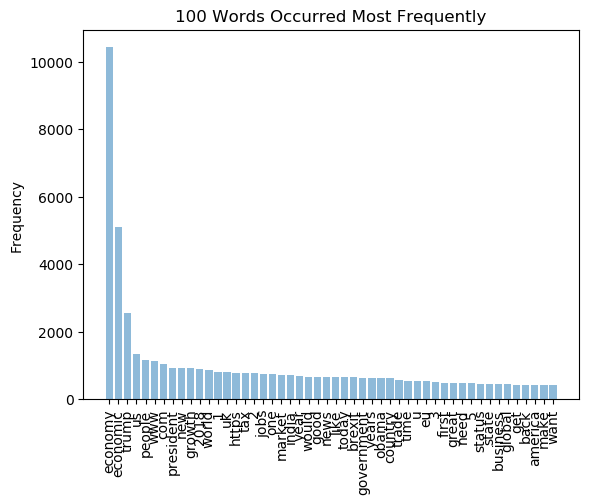

In [15]:
# draw a bar chart to show the frequency of the 100 most common words
x_word = word_freq_dist.iloc[0:50,0]
y_pos = np.arange(len(x_word))
y_freq = word_freq_dist.iloc[0:50,1]

plt.bar(y_pos, y_freq, align='center', alpha=0.5)
plt.xticks(y_pos, x_word)
plt.ylabel('Frequency')
plt.title('100 Words Occurred Most Frequently')
plt.xticks(rotation=90)
 
plt.show()

In [16]:
#split Tweet data into trainning set and text set 
#total tweet data is 20478, 60% will be used to train the model.
train_sentiment=tweetData.iloc[0:12285,:]
test_sentiment=tweetData.iloc[12285:,:]

In [17]:
# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 5     # Number of parallel threads
context = 10       # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
model = word2vec.Word2Vec(train_sentiment.tweet,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

In [18]:
# This will give the total number of words in the vocabolary created from this dataset
model.wv.syn0.shape

/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


(723, 300)

In [19]:
# This will print the most similar words present in the model
model.wv.most_similar("economic")

[('project', 0.9906215667724609),
 ('public', 0.9858954548835754),
 ('technology', 0.9847781658172607),
 ('energy', 0.9846606850624084),
 ('latest', 0.9843843579292297),
 ('leaders', 0.9843530654907227),
 ('minister', 0.9841612577438354),
 ('canada', 0.9840447306632996),
 ('industry', 0.9840257167816162),
 ('environment', 0.9838099479675293)]

In [20]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [21]:
#Vectorize the training set
train_FeatureVecs = np.zeros((len(train_sentiment),num_features),dtype="float32")
counter=0
for tweet in train_sentiment:
    train_FeatureVecs[counter,:] = featureVecMethod(tweet, model, num_features)
    counter=counter+1
#testing: print out the first 50 features of the first training tweet
print(train_FeatureVecs[0,0:50])
print(counter)

[-0.14992502  0.07154259 -0.02665841 -0.04385803 -0.01252624  0.00918776
  0.02122934  0.06098749  0.05642305 -0.03469912 -0.01130071 -0.05296703
 -0.00352693  0.08718577 -0.06910163 -0.0570459   0.02401728  0.04109377
 -0.05519208  0.04414865 -0.1528634  -0.01926175 -0.0470896  -0.0701536
 -0.01326755  0.02622039 -0.04902607  0.04260651 -0.06182535 -0.04156384
 -0.0070907   0.07592495 -0.03131347 -0.06058025  0.06168734  0.03665787
 -0.05411942 -0.04035277 -0.02529794  0.06937677  0.01757798 -0.01791217
 -0.06477512  0.08571683 -0.06125176  0.03282664 -0.02200449 -0.07518894
  0.00055106  0.04559939]
3


/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [22]:
#Vectorize the test set
test_FeatureVecs=np.zeros((len(test_sentiment),num_features),dtype="float32")
counter_test=0
for each_test_tweet in test_sentiment:
    test_FeatureVecs[counter,:] = featureVecMethod(each_test_tweet, model, num_features)
    counter_test=counter_test+1
#testing: print out the first 50 features of the first testing tweet
print(test_FeatureVecs[0,0:50])
print(counter_test)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
3


/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [23]:
# Fitting a random forest classifier to the training data
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit(train_FeatureVecs, train_sentiment["score"])

In [25]:
# Predicting the sentiment values for test data
result = forest.predict(test_FeatureVecs)
output = pd.DataFrame(data={"date":test_sentiment["date"], "score":result})
output.to_csv( "/Users/Mandy/Desktop/output.csv", index=False, quoting=3 )
print(output.head())

         date  score
13102  3/1/18  1    
13103  3/1/18  1    
13104  3/1/18  1    
13105  3/1/18  1    
13106  3/1/18  1    
